In [3]:
#!{sys.executable} -m pip install --upgrade deepracer-utils


In [26]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


In [27]:
from deepracer.tracks import TrackIO, Track, GeometryUtils, TrackPlotter
from deepracer.tracks.track_utils import track_breakdown, track_meta
import math
import numpy as np


In [28]:
tu = TrackIO()
track_name = "reinvent_base"
track: Track = tu.load_track(track_name)


Loaded 71 waypoints


<__array_function__ internals>:180: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


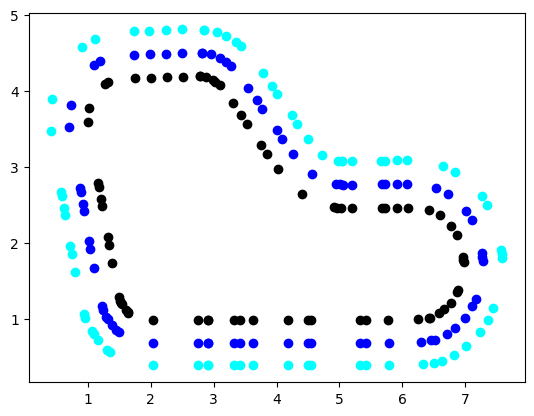

In [29]:
TrackPlotter.plot_track(track)


In [72]:
assert len(track.outer_border) == len(track.inner_border)
track.outer_border
track.inner_border

track_widths = []
for i, _ in enumerate(track.outer_border):
    track_widths.append(
        math.dist(track.outer_border[i], track.inner_border[i]))

track_widths[:5]


([0.6017725800257864,
  0.6017236843242613,
  0.6017117585434013,
  0.6016867135492646,
  0.6016199300307823],
 71)

In [101]:
track.center_line[0], track.center_line[-1]

(array([2.90999528, 0.68319247]), array([2.90999528, 0.68319247]))

In [73]:
len(track_widths)

71

In [61]:
max(track_widths), min(track_widths), sum(track_widths) / len(track_widths)


(0.6242015289254961, 0.5906041356688785, 0.6089869570222295)

In [62]:
def put_to_origin(closest_waypoint, the_second_closest_wp, furthest_waypoint) -> tuple:
    """Move all the vectors to the origin relative to the closest_waypoint"""
    new_closest_wp = (0, 0)
    new_second_closest_wp = (
        the_second_closest_wp[0] - closest_waypoint[0], the_second_closest_wp[1] - closest_waypoint[1])
    new_furthest_wp = (
        furthest_waypoint[0] - closest_waypoint[0], furthest_waypoint[1] - closest_waypoint[1])
    return (new_closest_wp,  new_second_closest_wp, new_furthest_wp)
    
tests = [
    {
        'data': ((-4, 8), (-4, 4), (-8, 4)),
        'expected_point': ((0, 0), (0, -4), (-4, -4))
    },
]

for test in tests:
    result = put_to_origin(*test['data'])
    
    for i, point in enumerate(result):
        expected_point = test['expected_point'][i]
        calculated_point = result[i]
        assert expected_point[0] == calculated_point[0] and expected_point[1] == calculated_point[1], f'Result {calculated_point} did not match expected value {expected_point}'
        print(f'For test {test["data"]}, expected value {expected_point} and got {calculated_point}')

For test ((-4, 8), (-4, 4), (-8, 4)), expected value (0, 0) and got (0, 0)
For test ((-4, 8), (-4, 4), (-8, 4)), expected value (0, -4) and got (0, -4)
For test ((-4, 8), (-4, 4), (-8, 4)), expected value (-4, -4) and got (-4, -4)


In [63]:
def angle_of_vectors(ab,cd):
    """Returns the angle of the vectors"""
    dot_product = ab[0]*cd[0] + ab[1]*cd[1]
    mod_of_vector_1 = math.sqrt( ab[0]** 2 + ab[1]** 2)*math.sqrt(cd[0] ** 2 + cd[1] ** 2) 
    angle = dot_product/mod_of_vector_1
    angle_in_degree = math.degrees(math.acos(angle))
    return angle_in_degree
 
tests = [
    {
        'data': ((8,6), (7,9)),
        'expected_angle': 15.255118703057764
    },
    {
        'data': ((8,6), (7,9)),
        'expected_angle': 15.255118703057764
    },
]

for test in tests:
    result = angle_of_vectors(test['data'][0], test['data'][1])
    expected_angle = test['expected_angle']
    calculated_angle = result
    assert expected_angle == calculated_angle, f'Result {calculated_angle} did not match expected value {expected_angle}'
    print(f'For test {test["data"]}, expected value {expected_angle} and got {calculated_angle}')

For test ((8, 6), (7, 9)), expected value 15.255118703057764 and got 15.255118703057764
For test ((8, 6), (7, 9)), expected value 15.255118703057764 and got 15.255118703057764


In [64]:
def rotate_around_origin(origin, point, angle, decimel_points=2) -> tuple:
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    angle = math.radians(angle)
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    
    return round(qx, decimel_points), round(qy, decimel_points)

tests = [
    {
        'data': ((0, 0), (-4, -4), 180),
        'expected_point': (4, 4)
    },
]


for test in tests:
    result = rotate_around_origin(*test['data'])
    
    for i, point in enumerate(result):
        expected_point = test['expected_point']
        calculated_point = result
        print('Result was,', result)
        assert expected_point[0] == calculated_point[0] and expected_point[1] == calculated_point[1], f'Result {calculated_point} did not match expected value {expected_point}'
        print(bcolors.OKGREEN + "Test Passes" + bcolors.ENDC)
        print(f'For test {test["data"]}, expected value {expected_point} and got {calculated_point}')


Result was, (4.0, 4.0)
Test Passes
For test ((0, 0), (-4, -4), 180), expected value (4, 4) and got (4.0, 4.0)
Result was, (4.0, 4.0)
Test Passes
For test ((0, 0), (-4, -4), 180), expected value (4, 4) and got (4.0, 4.0)


In [65]:
def transform_to_origin(closest_waypoint, the_second_closest_wp, furthest_waypoint) -> tuple:
    """Align the vectors so that the closest and second closest waypoint are 0 on the x axis. This depends on the closest waypoint having the coordinates origin at 0,0"""
    assert(closest_waypoint[0] == 0 and closest_waypoint[1] == 0 ,   'closest_waypoint[0] == 0 and closest_waypoint[1]', closest_waypoint[0] , closest_waypoint[1] )
    second_point_origin_dist = math.dist((0,0), the_second_closest_wp)
    second_point_transformed = (0, second_point_origin_dist)
    degrees_of_rotation_needed = angle_of_vectors(second_point_transformed, the_second_closest_wp)
    
    new_second_closest_wp = rotate_around_origin(closest_waypoint, the_second_closest_wp, degrees_of_rotation_needed)

    new_furthest_wp = rotate_around_origin(closest_waypoint, furthest_waypoint, degrees_of_rotation_needed)

    return ( closest_waypoint, new_second_closest_wp, new_furthest_wp )

tests = [
    {
        'data': ((0, 0), (0, -4), (-4, -4)),
        'expected_point': ((0, 0), (0, 4), (4, 4))
    },
]

for test in tests:
    result = transform_to_origin(*test['data'])
    print('Result', result,'Test', test)
    
    for i, point in enumerate(result):
        expected_point = test['expected_point'][i]
        calculated_point = result[i]
        assert expected_point[0] == calculated_point[0] and expected_point[1] == calculated_point[1], f'Result {calculated_point} did not match expected value {expected_point}'
        print(f'For test {test["data"]}, expected value {expected_point} and got {calculated_point}')

Result ((0, 0), (0.0, 4.0), (4.0, 4.0)) Test {'data': ((0, 0), (0, -4), (-4, -4)), 'expected_point': ((0, 0), (0, 4), (4, 4))}
For test ((0, 0), (0, -4), (-4, -4)), expected value (0, 0) and got (0, 0)
For test ((0, 0), (0, -4), (-4, -4)), expected value (0, 4) and got (0.0, 4.0)
For test ((0, 0), (0, -4), (-4, -4)), expected value (4, 4) and got (4.0, 4.0)


<>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_571098/68622081.py:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(closest_waypoint[0] == 0 and closest_waypoint[1] == 0 ,   'closest_waypoint[0] == 0 and closest_waypoint[1]', closest_waypoint[0] , closest_waypoint[1] )


In [69]:


def get_angle_deg(closest_waypoint, the_second_closest_wp, furthest_waypoint):
    """Get angle in degrees"""
    
    closest_waypoint, the_second_closest_wp, furthest_waypoint = put_to_origin(closest_waypoint, the_second_closest_wp, furthest_waypoint)
    closest_waypoint, the_second_closest_wp, furthest_waypoint = transform_to_origin(closest_waypoint, the_second_closest_wp, furthest_waypoint)

    angle = math.degrees(math.atan2(
        furthest_waypoint[0], furthest_waypoint[1]))
    return angle


tests = [
    {
        'data': ((0, 0), (0, 5), (-5, 5)),
        'expected_ang': -45
    },
    {
        'data': ((0, 0), (0, 5), (-4, 0)),
        'expected_ang': -90
    },
    {
        'data': ((0, 0), (0, 5), (-5, 0)),
        'expected_ang': -90
    },
    {
        'data': ((0, 0), (0, 5), (-5, 0)),
        'expected_ang': -90
    },
    {
        'data': ((-5, 7), (-5, 4), (-8, 4)),
        'expected_ang': 45
    },
]

for test in tests:
    result = get_angle_deg(*test['data'])
    expected_angle = test['expected_ang']
    print(f'For test {test}, expected value {expected_angle} and got {result}')
    assert expected_angle == result, f'Result {result} did not match expected value {expected_angle}'


For test {'data': ((0, 0), (0, 5), (-5, 5)), 'expected_ang': -45}, expected value -45 and got -45.0
For test {'data': ((0, 0), (0, 5), (-4, 0)), 'expected_ang': -90}, expected value -90 and got -90.0
For test {'data': ((0, 0), (0, 5), (-5, 0)), 'expected_ang': -90}, expected value -90 and got -90.0
For test {'data': ((0, 0), (0, 5), (-5, 0)), 'expected_ang': -90}, expected value -90 and got -90.0
For test {'data': ((-5, 7), (-5, 4), (-8, 4)), 'expected_ang': 45}, expected value 45 and got 45.0


In [102]:
angles = []

for i, _ in enumerate(track.center_line):
    is_last_index = i == len(track.center_line) - 1
    is_second_last_index = i == len(track.center_line) - 2
    
    if is_last_index == True:
        print('Is last index', i)
        print('Break on last index because it is a repeat of the first waypoint')
        break
    
    if is_second_last_index == True:
        print('is_second_last_index', i)
        
        
    # print('is_last_index',is_last_index,'is_second_last_index',is_second_last_index)
    last_index = i+1

    second_point = track.center_line[0] if is_last_index else track.center_line[last_index]

    third_point = track.center_line[0] if is_second_last_index else \
        track.center_line[1] \
        if is_last_index \
        else track.center_line[i+2]

    current_wp = track.center_line[i]
    
    angle_result = get_angle_deg(
        current_wp, second_point, third_point)
    
    if math.isnan(angle_result):
        print('Angle result', angle_result)
        print('NaN was found')
        print(  
            'is_last_index', is_last_index,
            'is_second_last_index', is_second_last_index,
            'current_wp', current_wp,
            'last_index', last_index,
            'second_point', second_point,
            'third_point', third_point,
        )


    angles.append(angle_result)
    

print('Angles \n', angles)
print(
    f'The individual angles stats are, right_max: {max(angles)}, left_max: {min(angles)}, mean: {sum(angles) / len(angles)}, amount: {len(angles)}')


is_second_last_index 69
Is last index 70
Break on last index because it is a repeat of the first waypoint
Angles 
 [-0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.658543177563603, -1.6846843178962914, -0.0, -11.309932474020215, -4.763641690726178, -3.2704879231835657, -7.125016348901798, -3.6913859864512757, -13.134022306396325, -2.0454084888872277, -16.69924423399362, -27.552811576717797, -44.3414568224364, -85.51539399045538, -108.43494882292201, -146.79342968491048, -169.7778313663639, 178.40885972880542, 180.0, 178.89829388479365, 179.0759546472273, -180.0, -169.69515353123398, -156.80140948635182, -132.42085249971657, -93.46822925891715, -78.69006752597979, -78.46537934635528, -78.46537934635528, -78.69006752597979, -80.69005982501396, -88.8542371618249, -119.05460409907717, -128.6598082540901, -149.03624346792648, -167.90524292298792, 174.47245984834385, 178.97696981133217, 176.63353933657018, 176.63353933657018, 171.46923439005187, 159.3410899366925, 96.25403274391647, 61.741970

In [103]:
import pandas as pd

df = pd.DataFrame({ 'angles': angles })
df
# df.to_csv('./angles.csv')




,angles
0,-0.000000
1,0.000000
2,0.000000
3,-0.000000
4,0.000000
...,...
65,-4.085617
66,-13.348727
67,-7.744711
68,0.000000


Angle for wp -0.0 [2.90999528 0.68319247]
Angle for wp 0.0 [3.31999523 0.68333905]
Angle for wp 0.0 [3.41999522 0.6833748 ]
Angle for wp -0.0 [3.63000234 0.68344988]
Angle for wp 0.0 [4.18999512 0.68365009]
Angle for wp -0.0 [4.50000223 0.68376092]
Angle for wp -0.0 [4.54999507 0.68377879]
Angle for wp 0.0 [5.32000213 0.68405407]
Angle for wp -0.658543177563603 [5.42000211 0.68408983]
Angle for wp -1.6846843178962914 [5.78000207 0.68421853]
Angle for wp -0.0 [6.28974786 0.69214001]
Angle for wp -11.309932474020215 [6.46090648 0.71230635]
Angle for wp -4.763641690726178 [6.51369806 0.72102941]
Angle for wp -3.2704879231835657 [6.70428787 0.79959867]
Angle for wp -7.125016348901798 [6.83628178 0.88170048]
Angle for wp -3.6913859864512757 [6.99166336 1.00626532]
Angle for wp -13.134022306396325 [7.11420746 1.16932251]
Angle for wp -2.0454084888872277 [7.16583068 1.26342676]
Angle for wp -16.69924423399362 [7.28001974 1.76283083]
Angle for wp -27.552811576717797 [7.27289221 1.813237  ]
Ang

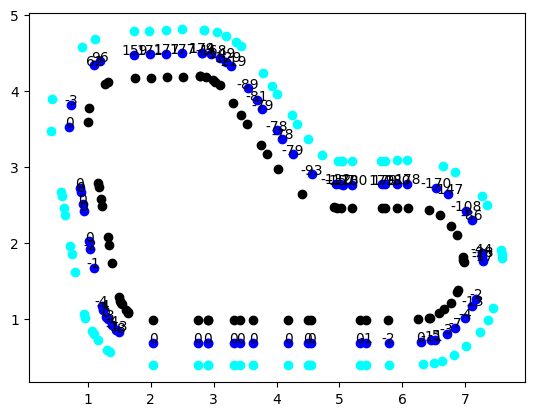

In [112]:
import matplotlib.pyplot as plt

def plot_coords(ax, track, angles, annotate=False, ):                                                        
    if annotate is True:                                                         
        for i, wp in enumerate(track.center_line):
            is_last_index = i == len(track.center_line) - 1

            if is_last_index == True:
                print('Is last index', i)
                print('Break on last index because it is a repeat of the first waypoint')
                return
            relative_angle = angles[i]
            print('Angle for wp', relative_angle, wp)
            plt.annotate(
                    str(round(angles[i])), # this is the text
                    (wp), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,0), # distance from text to points (x,y)
                    ha='center'
                ) # horizontal alignment can be left, right or center  
              
plot_coords(1, track, angles, True )
TrackPlotter.plot_track(track)

In [86]:
# CORNER_THRESHOLD_ANGLE = 0.5

# corners = []
# current_corner = {'id': 0}

# for i, _ in enumerate(track.center_line):

#     is_last_index = i == len(track.center_line) -1

#     second_point = track.center_line[0] if is_last_index else track.center_line[i+1]

#     angles.append(get_angle_deg(track.center_line[i], second_point))

# print(
#     f'The individual angles stats are, max: {max(angles)}, min: {min(angles)}, mean: {sum(angles) / len(angles)}')
